#Spam Detection Project

**IMPORTANT NOTE:** *The goal of this project is to expand and demonstrate skills in machine learning. In this notebook, I will not only explore the possibilities how to create, train and fine-tune NLP models, but also how to use AI tools - primarily LLM - ChatGPT 3.5. Some of the code below was written by AI and then checked and modified by me.*

In this project I will build a machine learning model that classifies emails as spam or ham (not spam).

To solve this problem I will explore two different methods:

1. F-IDF Vectorization + Multinomial Naive Bayes: In this approach, I will use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization technique to convert the email text into numerical features. I will then train a Multinomial Naive Bayes classifier for the classification task.

2. Deep Learning with TensorFlow and Keras: In this approach, I will build a neural network model using TensorFlow and Keras. I will use an Embedding layer to convert text data into numerical vectors, followed by an LSTM layer for sequence modeling and a Dense layer for binary classification.

*I also experimeted and tried to create Support Vector Machine (SVM) classifier with a linear kernel with one-hot encoding the data. This could be seen in section "Method 1.5"*

The data for this project is taken from [Kaggle](https://www.kaggle.com/datasets/venky73/spam-mails-dataset?resource=download)

In [113]:
# Providing my drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


Checking what devices are available (I will use CPU since I work with not large set of text data)

In [115]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


## Data Preprocessing

In [116]:
data = pd.read_csv('/content/drive/MyDrive/Projects/mail-spam-classifier/spam_ham_dataset.csv')

In [117]:
data.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [119]:
data.label_num.value_counts()

0    3672
1    1499
Name: label_num, dtype: int64

## Visualization

First I will create samples for spam and not spam emails

In [120]:
spam_text = " ".join(data[data['label'] == 'spam']['text'])
ham_text = " ".join(data[data['label'] == 'ham']['text'])

Now I will create WordClouds for both samples

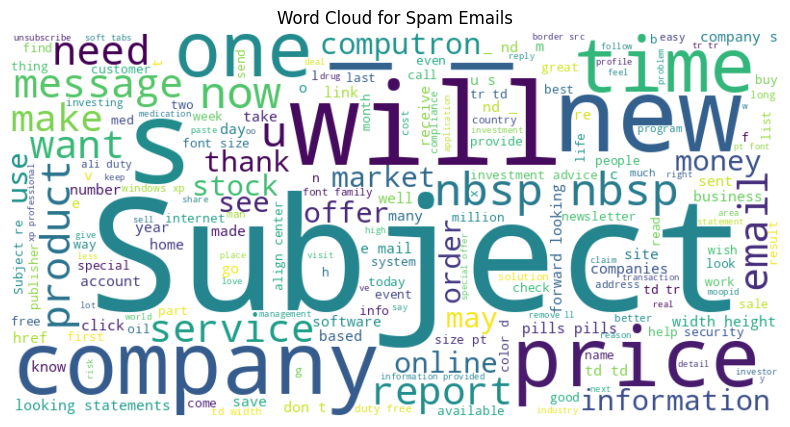

In [121]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')
plt.axis('off')
plt.show()

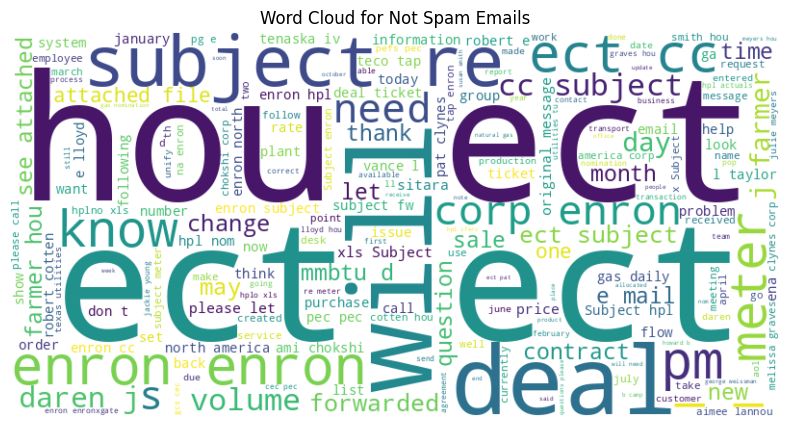

In [122]:
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Not Spam Emails')
plt.axis('off')
plt.show()

I will also create histograms that visualize the distribution of the email lengths

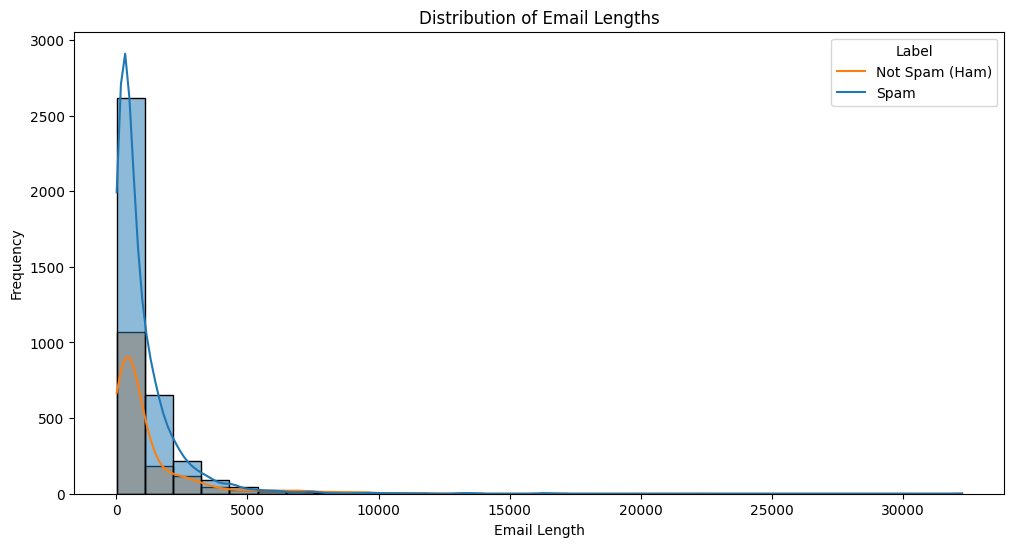

In [123]:
data['email_length'] = data['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='email_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.legend(title='Label', loc='upper right', labels=['Not Spam (Ham)', 'Spam'])
plt.show()

In [124]:
data['email_length'].describe()

count     5171.000000
mean      1048.391994
std       1528.513435
min         11.000000
25%        244.000000
50%        540.000000
75%       1237.000000
max      32258.000000
Name: email_length, dtype: float64

It seems that mails are disrtibuted not equally and there might be a lot of outliers. For visualizing I will delete the outliers.

In [125]:
data_deleted_outliers = data[(np.abs(stats.zscore(data['email_length'])) < 3)]

In [126]:
data_deleted_outliers['email_length'].describe()

count    5060.000000
mean      889.238933
std       973.791848
min        11.000000
25%       238.000000
50%       521.500000
75%      1175.250000
max      5630.000000
Name: email_length, dtype: float64

And now I will the distribution of the email lengths again

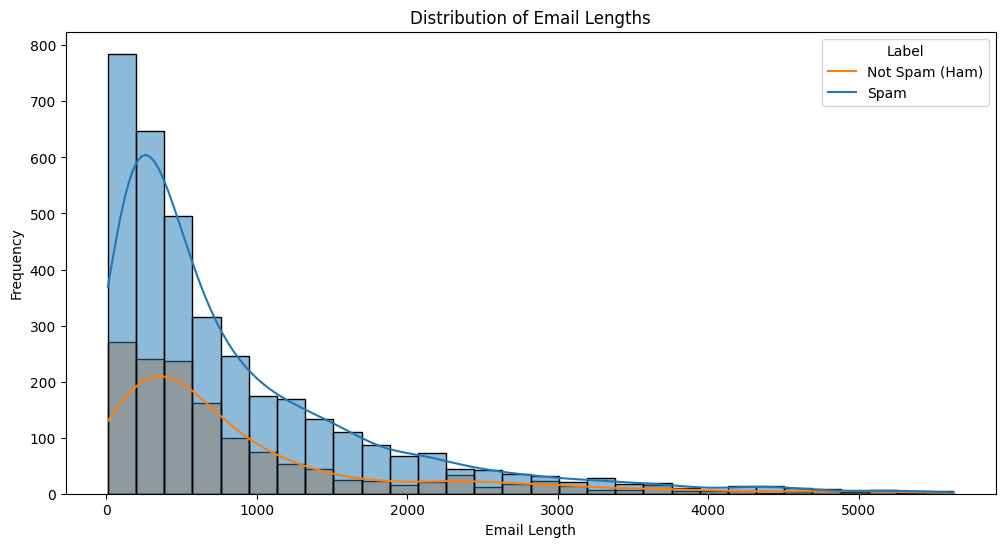

In [127]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_deleted_outliers, x='email_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.legend(title='Label', loc='upper right', labels=['Not Spam (Ham)', 'Spam'])
plt.show()

I will also create a distribution bar plot

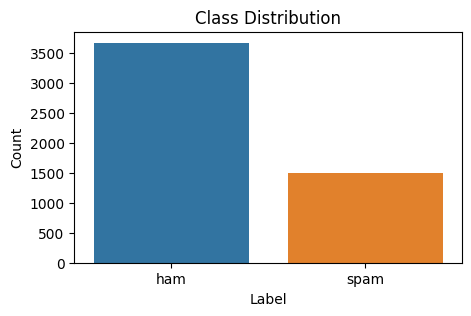

In [128]:
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='label')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Method 1: Scikit-learn with TF-IDF Vectorization and Multinomial Naive Bayes

## Building the model

First I will split my data into train and test datsets

In [129]:
X = data['text']
y = data['label_num']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [131]:
X_train[3]

'Subject: photoshop , windows , office . cheap . main trending\r\nabasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogarty clears bayda\r\ninconveniencing managing represented smartness hashish\r\nacademies shareholders unload badness\r\ndanielson pure caffein\r\nspaniard chargeable levin\r\n'

Now I will use TF-IDF vectorization to convert a collection of mails into numerical feature vectors.

The TF-IFD Score (Team Frequency - Inverse Document Frequency) combines local importance (TF) and global importance (IDF) of the term.

Using TF-IDF I convert each document into a numerical vector.

In [132]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Now I will build the model - The Multinomial Naive Bayes Classifier. It is based on Bayes' theoren and makes assumtion that features are conditionally independent given the class label.

In [133]:
naive_bayes_classifier = MultinomialNB()

Now I will train the model and calculate the probability distribution of each feature for each class (spam or ham)

In [134]:
naive_bayes_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

The model predicts posterior probabilities for each class using Bayes' theorem.

In [135]:
y_pred = naive_bayes_classifier.predict(X_test_tfidf)
y_pred

array([0, 1, 0, ..., 1, 0, 0])

Now I will evaluate model's metrics

In [136]:
accuracy_sklearn = accuracy_score(y_test, y_pred)
print("Scikit-learn Model Accuracy:", accuracy_sklearn)
print("Classification Report (Scikit-learn):\n", classification_report(y_test, y_pred))

Scikit-learn Model Accuracy: 0.9603864734299516
Classification Report (Scikit-learn):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       742
           1       0.93      0.93      0.93       293

    accuracy                           0.96      1035
   macro avg       0.95      0.95      0.95      1035
weighted avg       0.96      0.96      0.96      1035



## Hyperparameter Tuning

I will perform model fine-tuning using GridSearchCV. I will try to tune *max_features* and *alpha* hyperparameters

In [137]:
# Creating hyperparameter grid
param_grid = {
    'tfidf__max_features': [500, 1000, 5000, 10000],  # Tuning max_features for TF-IDF
    'clf__alpha': [0.1, 0.5, 1.0, 1.5],  # Tuning alpha for Multinomial Naive Bayes
}

I will also create a pipeline for TF-IDF vectorizer and the model

In [138]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

Performing grid search with cross validation

In [139]:
grid_search = GridSearchCV(text_clf, param_grid,
                           cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1.0, 1.5],
                         'tfidf__max_features': [500, 1000, 5000, 10000]},
             verbose=1)

In [140]:
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'clf__alpha': 0.5, 'tfidf__max_features': 10000}


## Evaluation

Setting the best hyperparameters, making new prediction and reevaluating the model

In [141]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [142]:
print("Scikit-learn Model Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Classification Report (Scikit-learn):\n", classification_report(y_test, y_pred))

Scikit-learn Model Accuracy: 0.968
Classification Report (Scikit-learn):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.95      0.94      0.94       293

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



# Method 1.5: SVM
As an experiment I also want to try to use Support Vector Machine (SVM) classifier with a linear kernel and to try one-hot encoding of the data.

In [143]:
# Creating a CountVectorizer for one-hot encoding

vectorizer = CountVectorizer(binary=True)
X_train_one_hot = vectorizer.fit_transform(X_train)
X_test_one_hot = vectorizer.transform(X_test)

Creating the SVM classifier with a linear kernel

In [144]:
svm_classifier = SVC(kernel='linear')

In [145]:
svm_classifier.fit(X_train_one_hot, y_train)

SVC(kernel='linear')

In [146]:
y_pred = svm_classifier.predict(X_test_one_hot)

In [147]:
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.9642512077294686
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       742
           1       0.94      0.93      0.94       293

    accuracy                           0.96      1035
   macro avg       0.96      0.95      0.96      1035
weighted avg       0.96      0.96      0.96      1035



The model performs very well, but a little worse than the fine-tuned TF-IDF, Multinomial Naive Bayes model.

# Method 2: TensorFlow NLP Model

## Building the model

I tokenize and pad the text data using Keras's Tokenizer and pad_sequences functions.

In [148]:
max_words = 5000  # Maximum number of words to keep in the vocabulary
max_sequence_length = 100  # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train))

In [149]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

I create a binary classification model with an embedding layer, a dropout layer, an LSTM layer, and a dense output layer with a sigmoid activation function.

In [150]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

I compile the model with binary cross-entropy loss and accuracy as the metric. I use ADAM as an optimizer

In [151]:
custom_lr = 0.001
optimizer = Adam(learning_rate=custom_lr)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Creating callbacks

I will define EarlyStopping callback to stop fitting the model if accuracy on validation split stops increasing after 3 epochs


In [152]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


## Training the model

In [153]:
batch_size = 32
epochs = 20
model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs,
          validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/20
117/117 [==============================] - 24s 174ms/step - loss: 0.2775 - accuracy: 0.8882 - val_loss: 0.1199 - val_accuracy: 0.9517
Epoch 2/20
117/117 [==============================] - 21s 180ms/step - loss: 0.0620 - accuracy: 0.9823 - val_loss: 0.0799 - val_accuracy: 0.9734
Epoch 3/20
117/117 [==============================] - 21s 182ms/step - loss: 0.0273 - accuracy: 0.9938 - val_loss: 0.1036 - val_accuracy: 0.9686
Epoch 4/20
117/117 [==============================] - 23s 197ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.1090 - val_accuracy: 0.9783
Epoch 5/20
117/117 [==============================] - 19s 167ms/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.1064 - val_accuracy: 0.9758
Epoch 6/20
117/117 [==============================] - 19s 166ms/step - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.1040 - val_accuracy: 0.9686
Epoch 7/20
117/117 [==============================] - 20s 171ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.1196 - val_ac

## Evaluating the model

I will use the threshold of 0.5 to create a Boolean Array for each example in the test dataset. If the predicted probability is greater or equal 0.5 the text is classified as positive class (spam) and if it is less than 0.5, it is classified as the negative class (not spam).

In [154]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Model Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Classification Report:\n", classification_report(y_test, y_pred))

33/33 [==============================] - 3s 80ms/step
Model Accuracy: 0.979
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       742
           1       0.98      0.95      0.96       293

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



This models seems to have the highest accuracy comparing to the previous two models, so I nominate this model as the best one and save it.

In [155]:
# Save the model to a folder
model.save('/content/drive/MyDrive/Projects/mail-spam-classifier/models/model_TF_NLP.keras')

In [156]:
# saving tokenizer
with open('/content/drive/MyDrive/Projects/mail-spam-classifier/models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Testing on custom emails

Loading the best model and the tokenizer

In [157]:
max_words = 5000
max_sequence_length = 100

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Projects/mail-spam-classifier/models/model_TF_NLP.keras')  # Replace with the path to your model

with open('/content/drive/MyDrive/Projects/mail-spam-classifier/models/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [158]:
loaded_model.summary(), loaded_tokenizer

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 100)               91600     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 731701 (2.79 MB)
Trainable params: 731701 (2.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(None, <keras.src.preprocessing.text.Tokenizer at 0x7d8efe4bbee0>)

Now I want to create a function that takes text of some email as input and using the trained TensorFlow model from above predicts whether it is a spam and also provides some statistics for the text.

In [159]:
def predict_spam(text, model, tokenizer):
  """
  Takes text as an input, defines if it a spam, privides statistics.
  """
  # tokenizing and paddint the text
  text_sequence = tokenizer.texts_to_sequences([text])
  text_padded = pad_sequences(text_sequence, maxlen=max_sequence_length)
  # making a prediction
  prediction = model.predict(text_padded)[0][0]
  is_spam = "Spam" if prediction >= 0.5 else "Not Spam"

  # Creating wordc loud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  # Calculating and plotting the distribution ofd lengths
  word_lengths = [len(word) for word in text.split()]
  plt.figure(figsize=(10, 3))
  sns.histplot(word_lengths, bins=20, kde=True)
  plt.title('Distribution of Word Lengths in Email Text')
  plt.xlabel('Word Length')
  plt.ylabel('Frequency')

  # displaying the word cloud
  plt.figure(figsize=(10, 4))
  plt.subplot(121)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Word Cloud for Email Text')
  plt.axis('off')

  # visualizing the prediction
  plt.subplot(122)
  plt.bar(["Not Spam", "Spam"], [1 - prediction, prediction], color=['blue', 'red'])
  plt.title('Spam Prediction Probability')
  plt.ylabel('Probability')
  plt.ylim([0, 1])

  plt.tight_layout()
  plt.show()

  # printing the prediction
  print("Email is:", is_spam)
  print(f"Spam Probability:, {round(prediction*100, 2)}%")

Trying the function on some text that is generated by ChatGPT3.5 specifically for this purpose.

In [160]:
email_text = """
Dear Customer,

Congratulations! You've been selected as the Grand Prize Winner of our Annual Customer Appreciation Sweepstakes! You've won a brand new car, a luxury vacation for two to a tropical paradise, and $10,000 in cash!

To claim your prizes, please click on the link below and provide your personal information, including your name, address, social security number, and bank account details. This is to ensure a smooth and speedy delivery of your winnings.

[Link to Claim Your Prizes]

Hurry, this is a limited-time offer, and you must claim your prizes within the next 24 hours. Don't miss out on this once-in-a-lifetime opportunity!

Sincerely,
John Smith
Customer Service Manager
XYZ Sweepstakes, Inc.

PS: This email is not a scam. We are a legitimate company, and your winnings are guaranteed. Trust us!
"""

1/1 [==============================] - 1s 1s/step


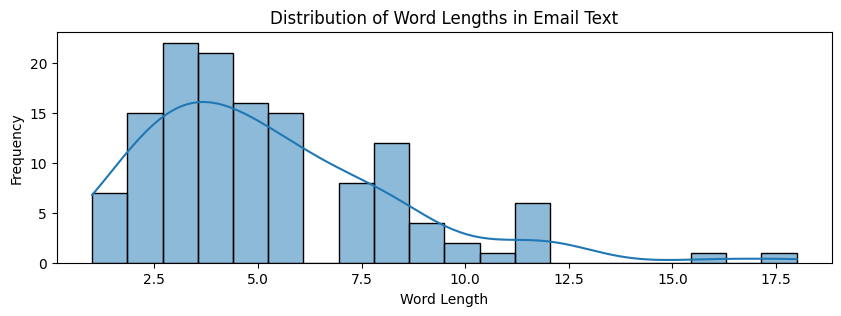

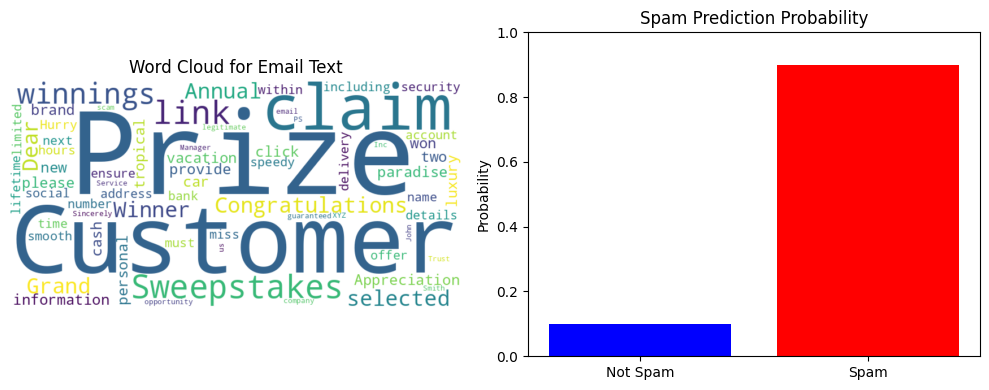

Email is: Spam
Spam Probability:, 90.03%


In [161]:
predict_spam(email_text, loaded_model, loaded_tokenizer)

In [162]:
email_text_2 = """
Dear Max,
I hope this email finds you well. We are excited to invite you to our upcoming webinar on
"Advanced Data Analysis Techniques." This informative session will be presented
by industry experts and will cover a range of topics including data visualization,
predictive modeling, and best practices in data analysis.

If you have any questions or need further information,
please feel free to reply to this email, and we'll be happy
to assist you.

We look forward to your participation and hope to see you at the webinar.

Best regards,
Michael
"""

1/1 [==============================] - 0s 131ms/step


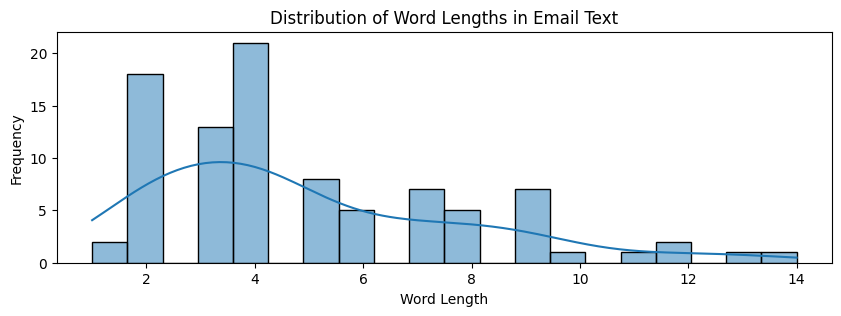

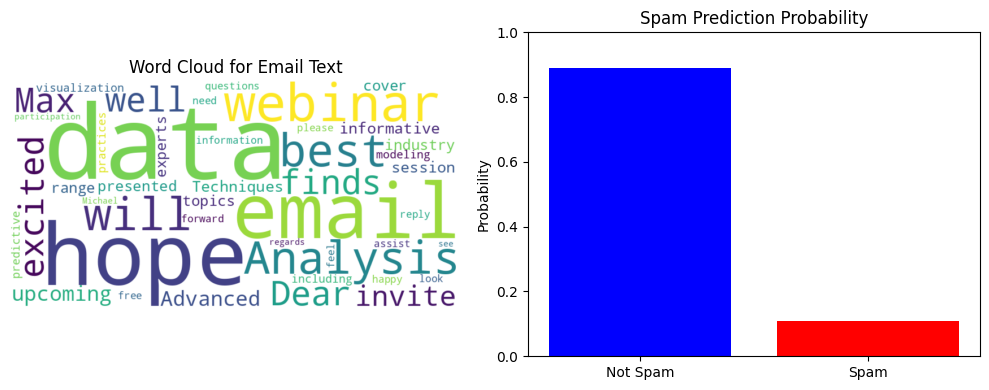

Email is: Not Spam
Spam Probability:, 10.98%


In [163]:
predict_spam(email_text_2, loaded_model, loaded_tokenizer)

In [164]:
email_text_3 = """
Lorem Ipsum is simply dummy text of the printing and typesetting industry.
Lorem Ipsum has been the industry's standard dummy text ever since the 1500s,
when an unknown printer took a galley of type and scrambled it to make a type specimen book.
It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged.
"""

1/1 [==============================] - 0s 58ms/step


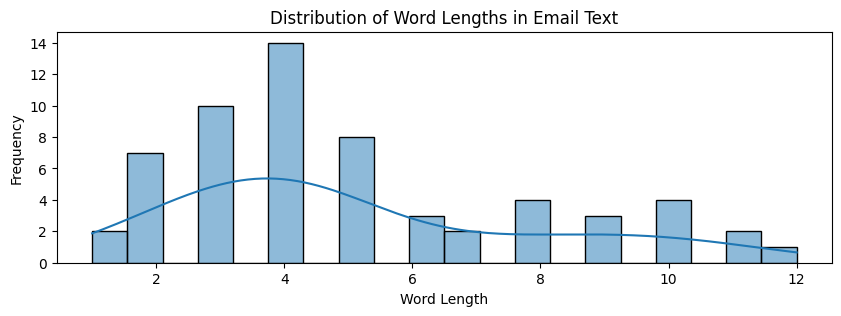

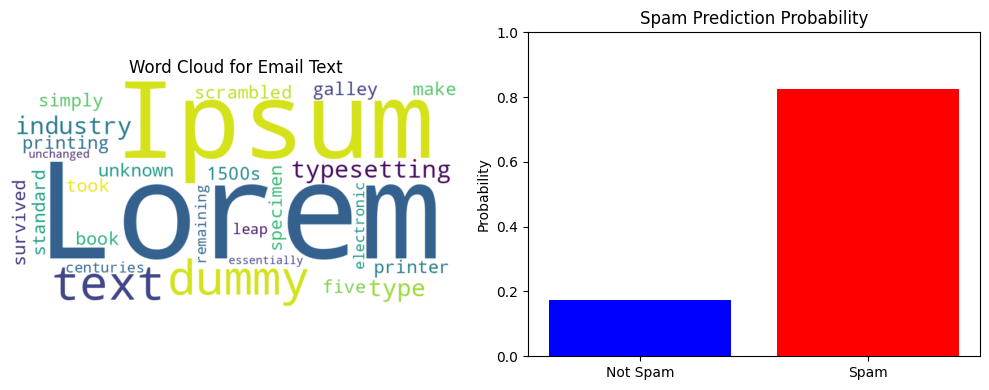

Email is: Spam
Spam Probability:, 82.55%


In [165]:
predict_spam(email_text_3, loaded_model, loaded_tokenizer)

After testing on 3 different examples, I think I can claim that the model performs quite well. It easily detected a spam email and a not-spam email (which contained an invitation to an event). However its performance was not that good when it was tested on generated Lorem Ipsum text